In [8]:
import sys
import os
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import glob
import json

project_root = os.path.dirname(os.path.abspath(os.getcwd()))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [9]:
# Constants
data_location = r"C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\results\final"
folders = [name for name in os.listdir(data_location)]
# Go one level deeper and get every pair of (folder, subfolder)
folder_pairs = []
for folder in folders:
    folder_path = os.path.join(data_location, folder)
    if os.path.isdir(folder_path):
        subfolders = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
        for subfolder in subfolders:
            folder_pairs.append((folder, subfolder))
print(folder_pairs)

[('orderbooks', 'AAPL'), ('orderbooks', 'BAC'), ('orderbooks', 'GOOG'), ('orderbooks', 'JPM'), ('orderbooks', 'META'), ('orderbooks', 'MSFT'), ('orderbooks', 'MTCH'), ('orderbooks', 'NFLX'), ('orderbooks', 'NVDA'), ('orderbooks', 'ORCL'), ('orderbooks', 'PLTR'), ('orderbooks', 'TSLA'), ('orderfixedvol', 'AAPL'), ('orderfixedvol', 'BAC'), ('orderfixedvol', 'GOOG'), ('orderfixedvol', 'JPM'), ('orderfixedvol', 'META'), ('orderfixedvol', 'MSFT'), ('orderfixedvol', 'MTCH'), ('orderfixedvol', 'NFLX'), ('orderfixedvol', 'NVDA'), ('orderfixedvol', 'ORCL'), ('orderfixedvol', 'PLTR'), ('orderfixedvol', 'TSLA'), ('orderflows', 'AAPL'), ('orderflows', 'BAC'), ('orderflows', 'GOOG'), ('orderflows', 'JPM'), ('orderflows', 'META'), ('orderflows', 'MSFT'), ('orderflows', 'MTCH'), ('orderflows', 'NFLX'), ('orderflows', 'NVDA'), ('orderflows', 'ORCL'), ('orderflows', 'PLTR'), ('orderflows', 'TSLA'), ('ordervol', 'AAPL'), ('ordervol', 'BAC'), ('ordervol', 'GOOG'), ('ordervol', 'JPM'), ('ordervol', 'META'

In [14]:
json_files = [
    {'Representation': representation, 'Ticker': ticker, 'File': f}
    for representation, ticker in folder_pairs
    for f in glob.glob(os.path.join(data_location, representation, ticker, "*.json"))
]

# Load and flatten all JSON files into a single list of records
def flatten_record(entry):
    with open(entry['File'], 'r') as file:
        data = json.load(file)
        records = data if isinstance(data, list) else [data]
        for record in records:
            record.update({'Representation': entry['Representation'], 'Ticker': entry['Ticker']})
            # Flatten nested dicts
            for key in ['meta', 'metrics', 'metricsStrength']:
                if key in record and isinstance(record[key], dict):
                    for k, v in record[key].items():
                        record[f"{key}.{k}"] = v
            yield record

all_data = [rec for entry in json_files for rec in flatten_record(entry)]

joined_df = pd.DataFrame(all_data)
# Reorder columns so that 'Representation' and 'Ticker' are first
cols = ['Representation', 'Ticker'] + [col for col in joined_df.columns if col not in ['Representation', 'Ticker']]
joined_df = joined_df[cols]
data = joined_df.copy()
data.shape

(672, 54)

In [15]:
print(data.columns)

Index(['Representation', 'Ticker', 'run_id', 'datetime', 'meta', 'metrics',
       'metricsStrength', 'meta.model', 'meta.modelKwargs', 'meta.numEpoch',
       'meta.batchSize', 'meta.ticker', 'meta.steps', 'meta.maxFiles',
       'meta.scaling', 'meta.threshold', 'meta.rowLim', 'meta.trainTestSplit',
       'meta.lookForwardHorizon', 'meta.representation', 'meta.labelType',
       'meta.archive', 'metrics.MSE', 'metrics.R2', 'metrics.MAPE',
       'metrics.MAE', 'metricsStrength.accuracy@>0.1',
       'metricsStrength.coverage@>0.1', 'metricsStrength.accuracy@>0.2',
       'metricsStrength.coverage@>0.2', 'metricsStrength.accuracy@>0.3',
       'metricsStrength.coverage@>0.3', 'metricsStrength.accuracy@>0.4',
       'metricsStrength.coverage@>0.4', 'metricsStrength.accuracy@>0.5',
       'metricsStrength.coverage@>0.5', 'metricsStrength.accuracy@>0.6',
       'metricsStrength.coverage@>0.6', 'metricsStrength.accuracy@>0.7',
       'metricsStrength.coverage@>0.7', 'metricsStrength.accu

In [16]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

result = data.groupby(['Representation', 'Ticker', 'meta.labelType'])['meta.lookForwardHorizon'].agg(lambda x: ','.join(map(str, sorted(x))))#.reset_index()
display(result)

Representation  Ticker  meta.labelType
orderbooks      AAPL    CATEGORICAL       10,20,40,60,80,100,200
                        REGRESSION        10,20,40,60,80,100,200
                BAC     CATEGORICAL       10,20,40,60,80,100,200
                        REGRESSION        10,20,40,60,80,100,200
                GOOG    CATEGORICAL       10,20,40,60,80,100,200
                        REGRESSION        10,20,40,60,80,100,200
                JPM     CATEGORICAL       10,20,40,60,80,100,200
                        REGRESSION        10,20,40,60,80,100,200
                META    CATEGORICAL       10,20,40,60,80,100,200
                        REGRESSION        10,20,40,60,80,100,200
                MSFT    CATEGORICAL       10,20,40,60,80,100,200
                        REGRESSION        10,20,40,60,80,100,200
                MTCH    CATEGORICAL       10,20,40,60,80,100,200
                        REGRESSION        10,20,40,60,80,100,200
                NFLX    CATEGORICAL       10,20,40,

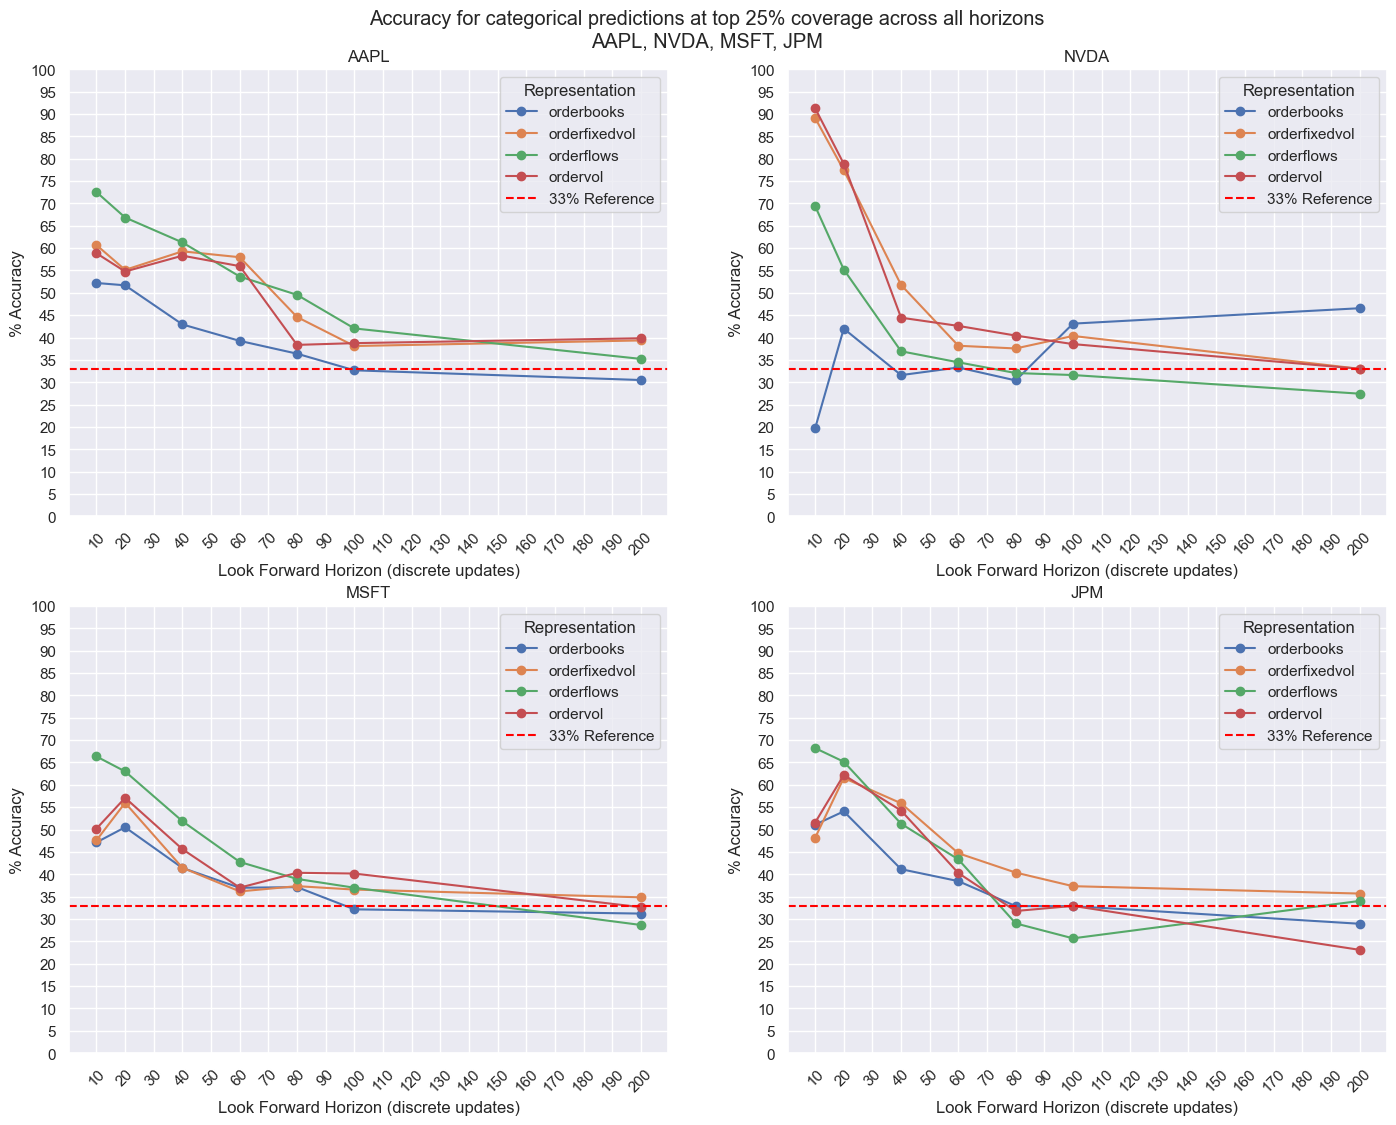

In [17]:
# Plotting
# ticker = 'NVDA'
tickers = ['AAPL', 'NVDA', 'MSFT', 'JPM']
labelType = 'CATEGORICAL'
y_axis_col = 'metricsStrength.accuracy@25%_coverage'
x_axis_col = 'meta.lookForwardHorizon'

fig, axes = plt.subplots(2, 2, figsize=(17, 12), sharey=False)
sns.set()
for ax, ticker in zip(axes.flatten(), tickers):
    filtered = data.loc[
        (data['meta.ticker'] == ticker) &
        (data['meta.labelType'] == labelType)
    ]
    df = filtered[['Ticker', 'meta.representation', x_axis_col, y_axis_col]]
    for rep in df['meta.representation'].unique():
        subset = df[df['meta.representation'] == rep].sort_values(by=x_axis_col)
        ax.plot(subset[x_axis_col], subset[y_axis_col] * 100, marker='o', label=rep)
    ax.set_xlabel("Look Forward Horizon (discrete updates)")
    ax.set_title(f"{ticker}")
    ax.grid(True)
    axHeight = 33 if labelType == 'CATEGORICAL' else 50
    ax.axhline(axHeight, color='red', linestyle='--', label=f'{int(axHeight)}% Reference')
    ax.legend(title="Representation")
    ax.set_ylabel("% Accuracy")
    ax.set_yticks(np.arange(0, 1.05, 0.05) * 100)
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_xticks(np.arange(10, 210, 10))

fig.suptitle(f"Accuracy for categorical predictions at top 25% coverage across all horizons\n{', '.join(tickers)}")
plt.subplots_adjust(top=0.93)
plt.show()

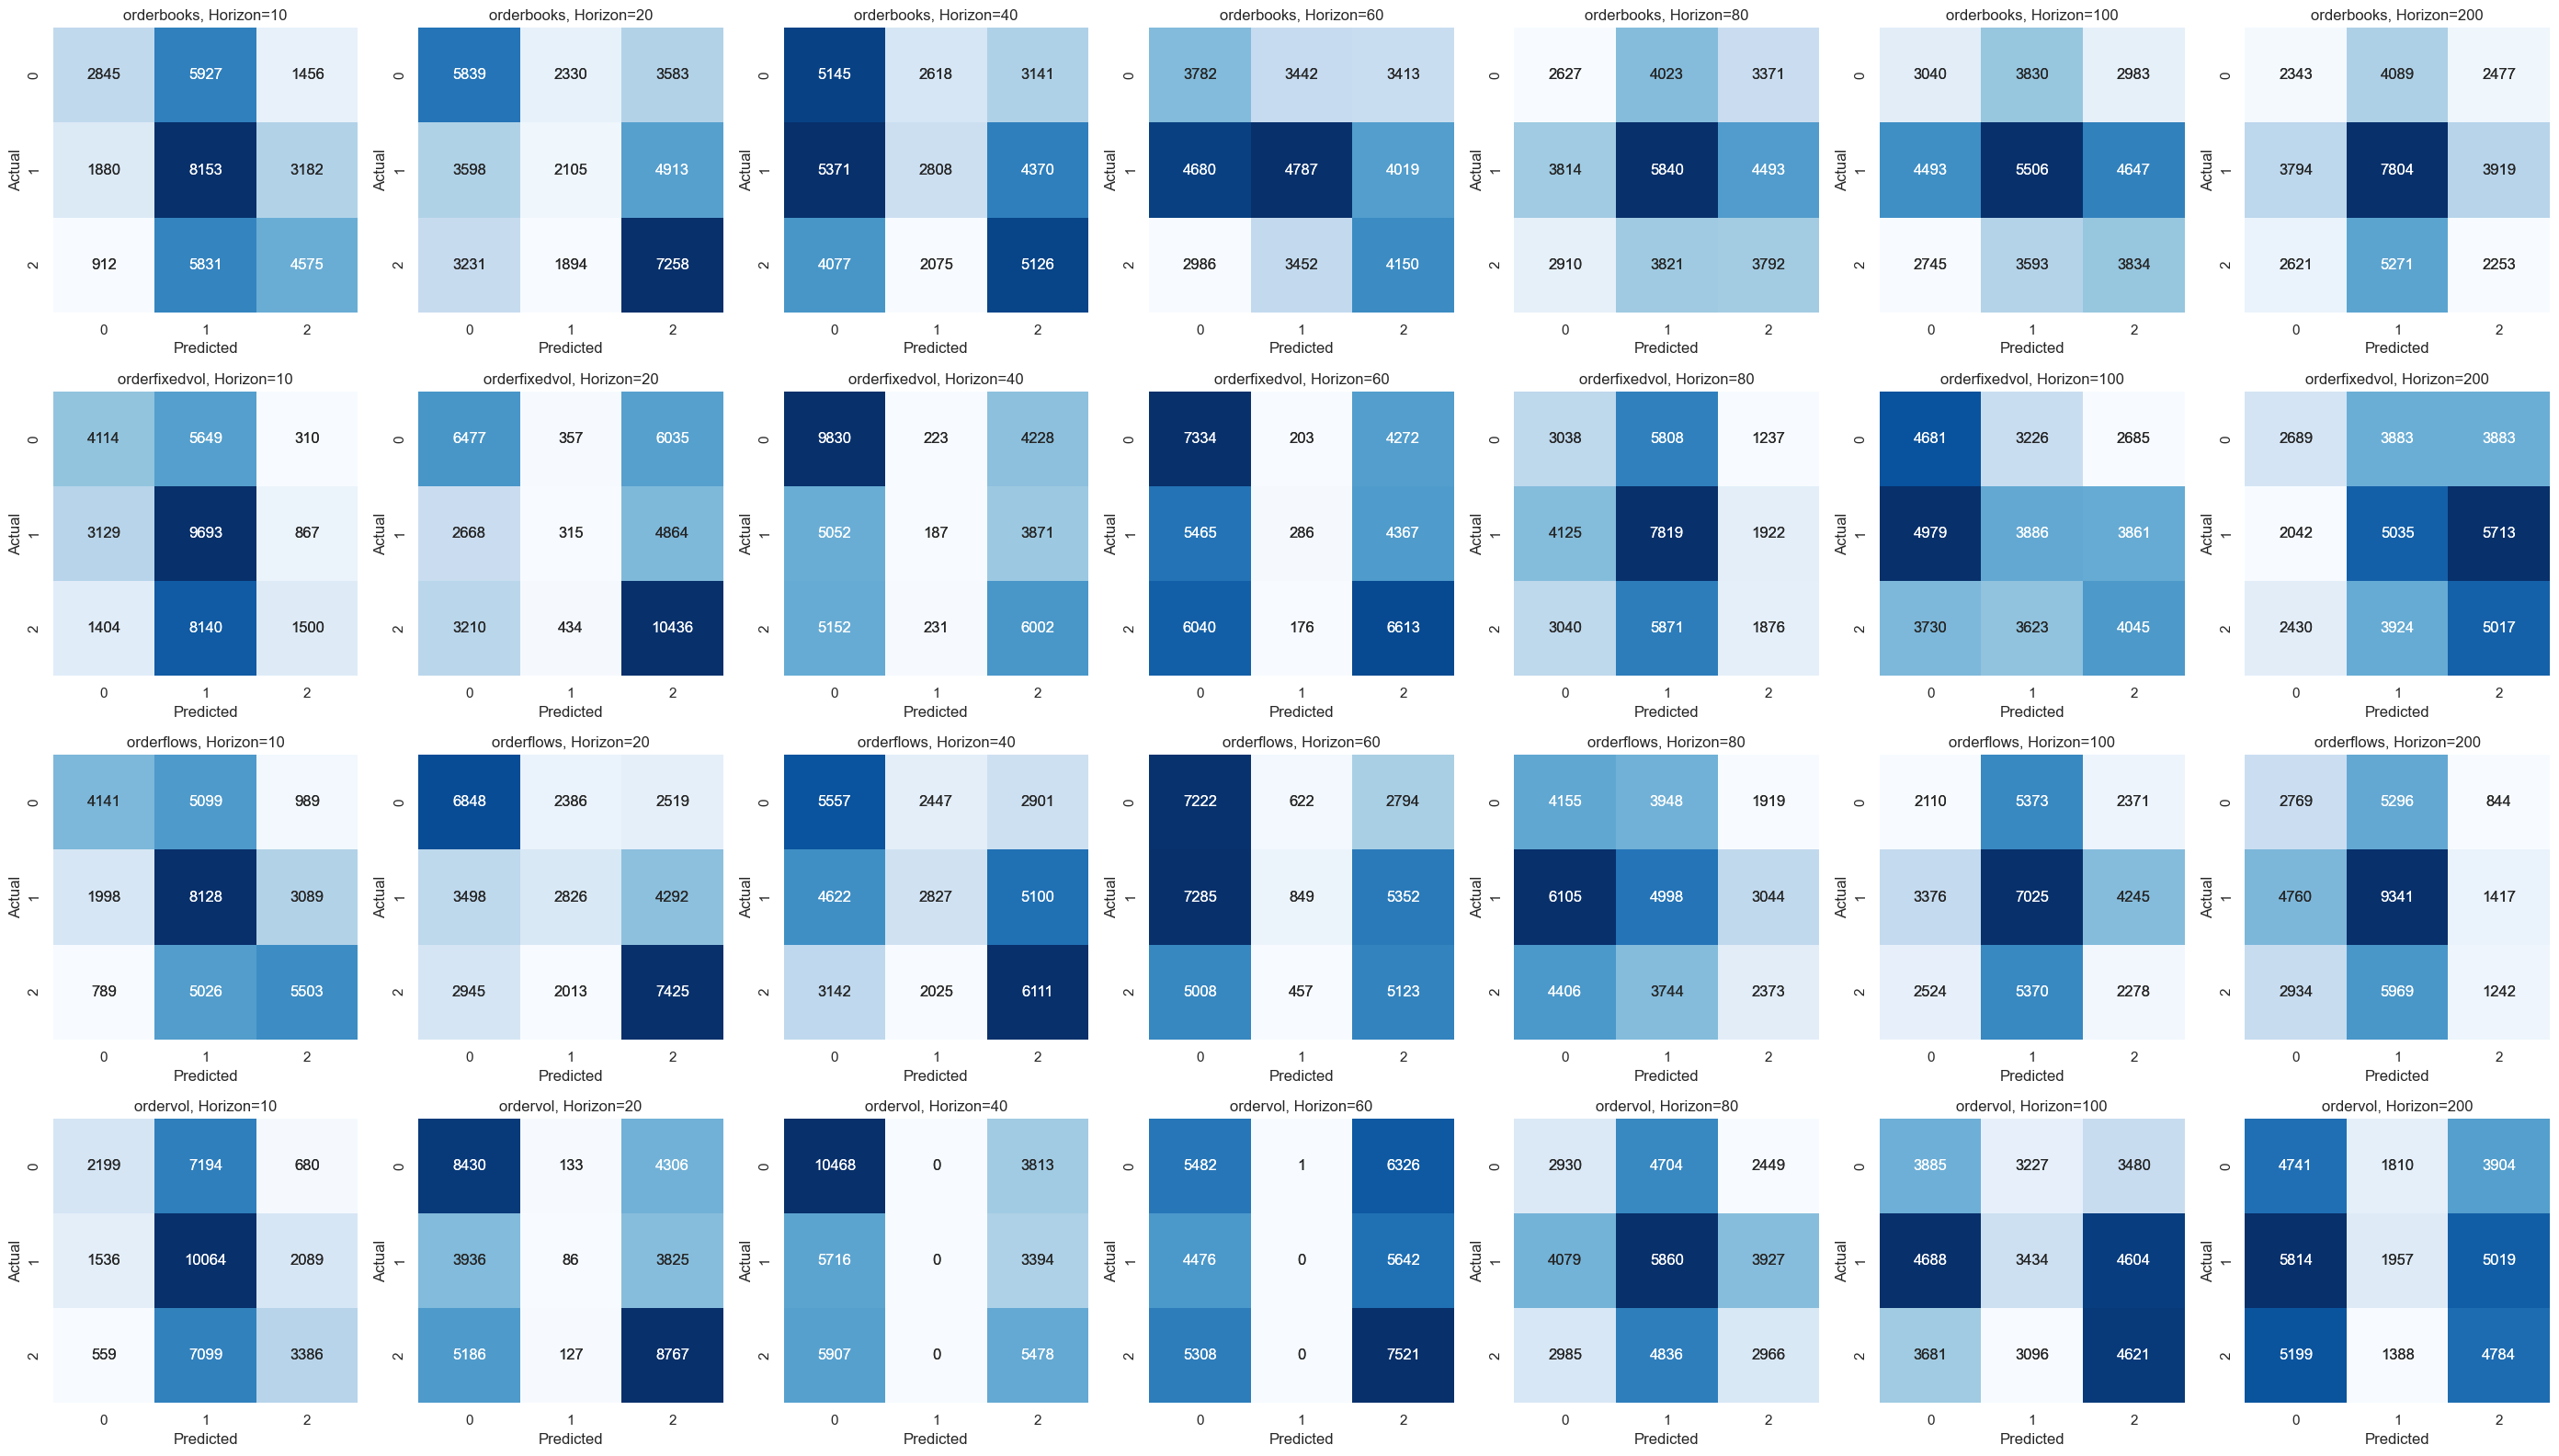

In [18]:
# Plotting
ticker = 'JPM'

filtered = data.loc[
    (data['meta.ticker'] == ticker) &
    (data['meta.labelType'] == 'CATEGORICAL')
]

df = filtered[['Ticker', 'meta.representation', 'meta.lookForwardHorizon', 'metrics.confusion_matrix', ]]

# Pivot the dataframe so that each row is a unique representation and each column is a lookForwardHorizon
pivot_df = df.pivot(index='meta.representation', columns='meta.lookForwardHorizon', values='metrics.confusion_matrix')

# Plot heatmaps for each cell in the pivot table
fig, axes = plt.subplots(nrows=pivot_df.shape[0], ncols=pivot_df.shape[1], figsize=(4 * pivot_df.shape[1], 4 * pivot_df.shape[0]))

for i, rep in enumerate(pivot_df.index):
    for j, horizon in enumerate(pivot_df.columns):
        cm = pivot_df.loc[rep, horizon]
        ax = axes[i, j] if pivot_df.shape[0] > 1 and pivot_df.shape[1] > 1 else axes[max(i, j)]
        sns.heatmap(np.array(cm), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        if isinstance(cm, list):
            sns.heatmap(np.array(cm), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
            ax.set_title(f"{rep}, Horizon={horizon}")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        else:
            ax.axis('off')
plt.tight_layout()
plt.show()

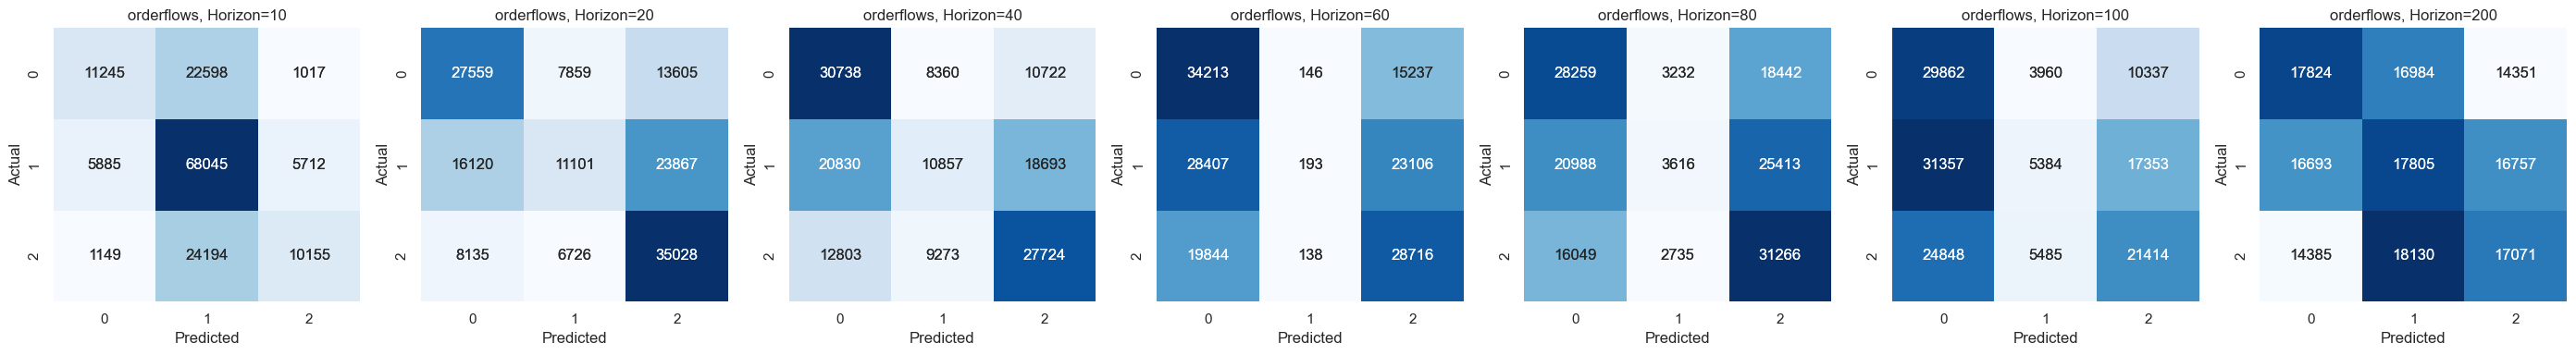

In [19]:
# Plotting
ticker = 'AAPL'
labelType = 'CATEGORICAL'
representation = 'orderflows'

filtered = data.loc[
    (data['meta.ticker'] == ticker) &
    (data['meta.labelType'] == labelType) &
    (data['meta.representation'] == representation)
    
]

df = filtered[['Ticker', 'meta.representation', 'meta.lookForwardHorizon', 'metrics.confusion_matrix', ]]

# Pivot the dataframe so that each row is a unique representation and each column is a lookForwardHorizon
pivot_df = df.pivot(index='meta.representation', columns='meta.lookForwardHorizon', values='metrics.confusion_matrix')

# Plot heatmaps for each cell in the pivot table
fig, axes = plt.subplots(nrows=pivot_df.shape[0], ncols=pivot_df.shape[1], figsize=(4 * pivot_df.shape[1], 4 * pivot_df.shape[0]))

for i, rep in enumerate(pivot_df.index):
    for j, horizon in enumerate(pivot_df.columns):
        cm = pivot_df.loc[rep, horizon]
        ax = axes[i, j] if pivot_df.shape[0] > 1 and pivot_df.shape[1] > 1 else axes[max(i, j)]
        sns.heatmap(np.array(cm), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        if isinstance(cm, list):
            sns.heatmap(np.array(cm), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
            ax.set_title(f"{rep}, Horizon={horizon}")
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        else:
            ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# From src\notebooks\exploratoryDataAnalysis.ipynb run on linux
avg_time_map = {
    'AAPL': 0.016324748125661145,
    'MSFT': 0.05652782381722122,
    'NFLX': 0.28448296189298344,
    'NVDA': 0.008002265498323332,
    'META': 0.06260781371282477,
    'GOOG': 0.011790209912208208,
    'MTCH': 0.4402842687979989,
    'BAC': 0.08487866186096288,
    'JPM': 0.09554441588830866,
    'PLTR': 0.00968540544796652,
    'WFC': 0.03834952569793524,
    'TSLA': 0.011167860198824656,
    'ORCL': 0.16073876408434803
}

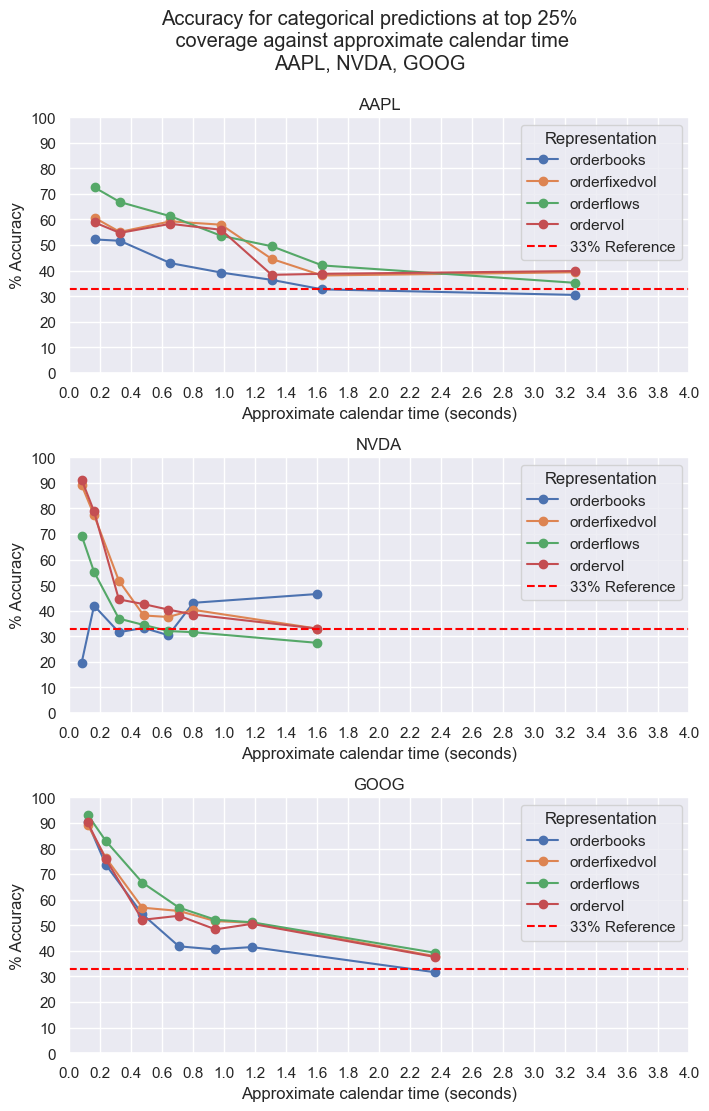

In [21]:
# Plotting
# ticker = 'NVDA'
tickers = ['AAPL', 'NVDA', 'GOOG']
ticker = 'AAPL'
labelType = 'CATEGORICAL'
y_axis_col = 'metricsStrength.accuracy@25%_coverage'
x_axis_col = 'meta.lookForwardHorizon'

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharey=False)
sns.set()
for ax, ticker in zip(axes.flatten(), tickers):
    filtered = data.loc[
        (data['meta.ticker'] == ticker) &
        (data['meta.labelType'] == labelType)
    ]
    df = filtered[['Ticker', 'meta.representation', x_axis_col, y_axis_col]]
    for rep in df['meta.representation'].unique():
        subset = df[df['meta.representation'] == rep].sort_values(by=x_axis_col)
        x_vals = avg_time_map[ticker] * subset[x_axis_col]
        ax.plot(x_vals, subset[y_axis_col] * 100, marker='o', label=rep)
    ax.set_xlabel("Approximate calendar time (seconds)")
    ax.set_title(f"{ticker}")
    ax.grid(True)
    axHeight = 33 if labelType == 'CATEGORICAL' else 50
    ax.axhline(axHeight, color='red', linestyle='--', label=f'{int(axHeight)}% Reference')
    ax.legend(title="Representation")
    ax.set_ylabel("% Accuracy")
    ax.set_yticks(np.arange(0, 1.1, 0.1) * 100)
    plt.setp(ax.get_xticklabels(), rotation=0)
    ax.set_xticks(np.arange(0, 4.1, 0.2))

fig.suptitle(f"Accuracy for categorical predictions at top 25%\n coverage against approximate calendar time\n{', '.join(tickers)}")
plt.subplots_adjust(top=0.89, hspace=0.33)
plt.show()

C:\Users\benhu\AppData\Local\Temp\ipykernel_23572\3312745022.py:59: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


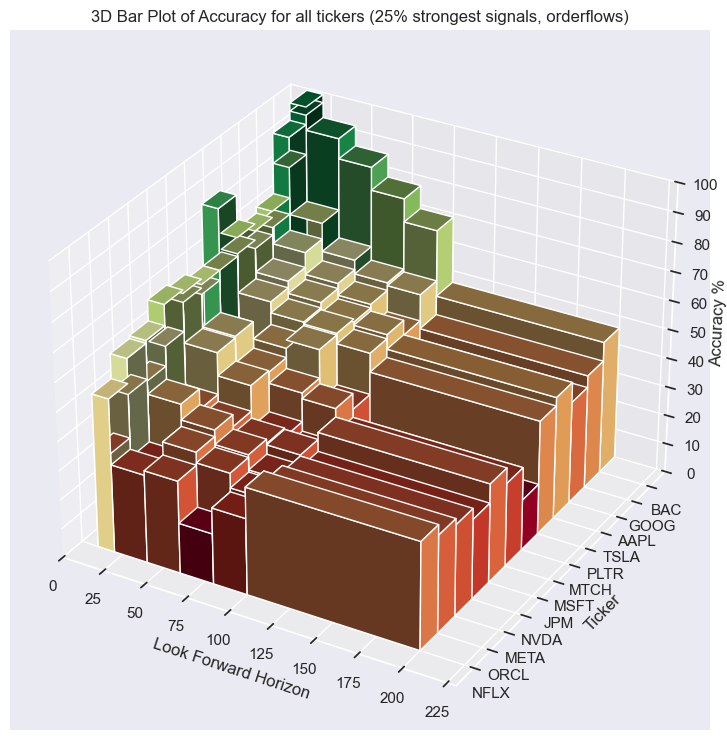

In [22]:
from mpl_toolkits.mplot3d import Axes3D
# sns.set(style='white')
sns.set()
rep = 'orderflows'
labelType = 'CATEGORICAL'
df_3d = data[
    (data['meta.representation'] == rep) &
    (data['meta.labelType'] == labelType)
]

avg_acc = df_3d.groupby('Ticker')['metricsStrength.accuracy@25%_coverage'].mean()
sorted_tickers = avg_acc.sort_values().index.tolist()
horizons = sorted(df_3d['meta.lookForwardHorizon'].unique())

fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(111, projection='3d')

x = np.array(horizons)
y = np.arange(len(sorted_tickers))
X, Y = np.meshgrid(x, y)
Z = np.empty_like(X, dtype=float)
for i, ticker in enumerate(sorted_tickers):
    for j, horizon in enumerate(horizons):
        val = df_3d[(df_3d['Ticker'] == ticker) & (df_3d['meta.lookForwardHorizon'] == horizon)]['metricsStrength.accuracy@25%_coverage']
        Z[i, j] = val.iloc[0] if not val.empty else np.nan

Z *=100

xpos, ypos = X.ravel(), Y.ravel()
zpos = np.zeros_like(xpos)
dz = Z.ravel()

dx_vals = -np.diff(x, prepend=x[0])
dx_vals[0] = horizons[0]
dx = np.tile(dx_vals, len(sorted_tickers))
dy = 1
surface_z = 0.33 * np.ones_like(X)
ax.plot_surface(X, Y, surface_z, color='red', alpha=0.2, linewidth=0, antialiased=False)
colors = plt.cm.RdYlGn((dz - np.nanmin(dz)) / (np.nanmax(dz) - np.nanmin(dz) + 1e-9))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color=colors)
ax.set_xlabel('Look Forward Horizon')
ax.set_ylabel('Ticker')
ax.set_zlabel('Accuracy %\n')
ax.set_title(f'3D Bar Plot of Accuracy for all tickers (25% strongest signals, {rep})')

ax.set_xlim(x.min() - 10, x.max() + 30)
ax.set_ylim(-1, len(sorted_tickers))
ax.set_zlim(0, np.nanmax(dz) + 0.1)
ax.set_zticks(np.arange(0, 110, 10))

ax.set_yticks(np.arange(len(sorted_tickers)))
ax.set_yticklabels(sorted_tickers)

pos = ax.get_position()
ax.set_position([pos.x0 - 0.15, pos.y0, pos.width, pos.height])

plt.subplots_adjust(right=1)

plt.tight_layout()
plt.show()


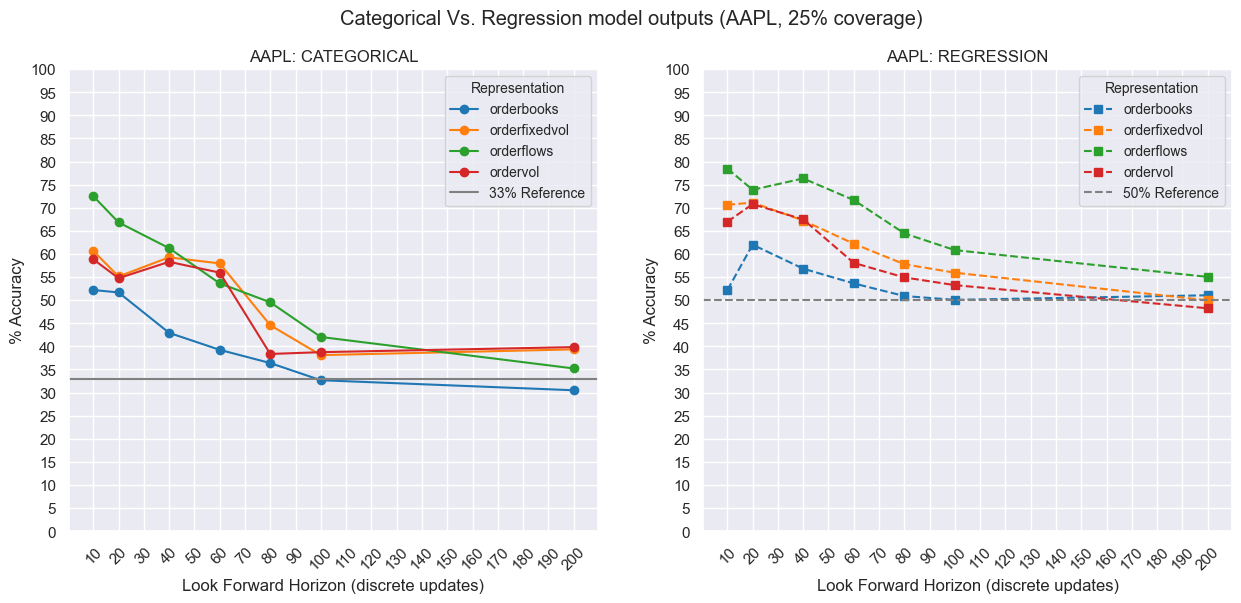

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)
sns.set()
label_types = ["CATEGORICAL", "REGRESSION"]
ticker = 'AAPL'
reps = data['meta.representation'].unique()
palette = sns.color_palette("tab10", len(reps))
rep_color_map = {rep: palette[i] for i, rep in enumerate(reps)}

for ax, labelType in zip(axes, label_types):
    filtered = data.loc[
        (data['meta.ticker'] == ticker) &
        (data['meta.labelType'] == labelType)
    ]
    df = filtered[['Ticker', 'meta.representation', x_axis_col, y_axis_col]]
    for rep in df['meta.representation'].unique():
        subset = df[df['meta.representation'] == rep].sort_values(by=x_axis_col)
        linestyle = '-' if labelType == 'CATEGORICAL' else '--'
        marker = 'o' if labelType == 'CATEGORICAL' else 's'
        ax.plot(
            subset[x_axis_col],
            subset[y_axis_col] * 100,
            marker=marker,
            label=rep,
            linestyle=linestyle,
            color=rep_color_map[rep]
        )
    ax.set_xlabel("Look Forward Horizon (discrete updates)")
    ax.set_title(f"{ticker}: {labelType}")
    ax.grid(True)
    axline = 33 if labelType == "CATEGORICAL" else 50
    ax.axhline(axline, color='grey', linestyle=linestyle, label=f'{axline}% Reference')
    ax.legend(title="Representation", fontsize='small', title_fontsize='small')
    ax.set_yticks(np.arange(0, 1.05, 0.05) * 100)
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_xticks(np.arange(10, 210, 10))
    ax.set_ylabel("% Accuracy")
# plt.tight_layout()
plt.suptitle(f"Categorical Vs. Regression model outputs ({ticker}, 25% coverage)")
plt.show()


0.344404


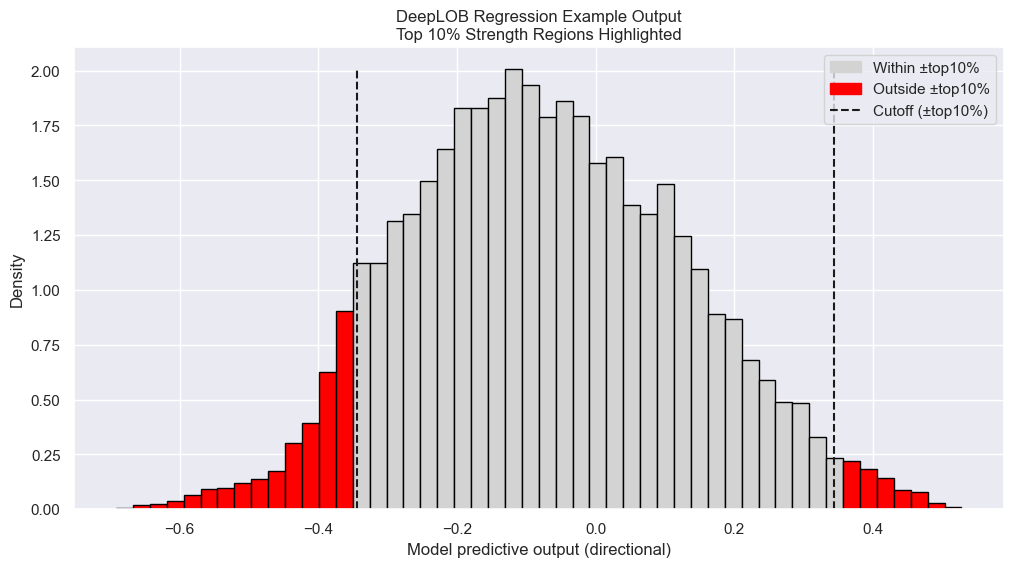

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Load data
path = r"C:\Users\benhu\UCL\Term 3\HSBC\deep-lob-project\results\csv_outputs\regression_prediction_examples.csv"
res_data = pd.read_csv(path)

values = res_data['0'].values

# Compute threshold
ordered = sorted(abs(values))
top25 = ordered[int(len(ordered)*0.90)]
print(top25)

fig = plt.figure(figsize=(12,6))
# Plot histogram manually
counts, bins, patches = plt.hist(values, bins=50, edgecolor='black', density=True)

# Color bars based on whether bin is outside [-top25, top25]
for index, (patch, left_edge) in enumerate(zip(patches, bins[:-1])):
    if left_edge + (bins[1] - bins[0]) < -top25 or left_edge > top25:
        patch.set_facecolor('red')   # outside region
    else:
        patch.set_facecolor('lightgrey')  # inside region

# Add vertical lines
plt.vlines(top25, ymin=0, ymax=max(counts), colors='k', linestyles='--')
plt.vlines(-top25, ymin=0, ymax=max(counts), colors='k', linestyles='--')

# Legend handles
inside_patch = mpatches.Patch(color='lightgrey', label='Within ±top10%')
outside_patch = mpatches.Patch(color='red', label='Outside ±top10%')
cutoff_line = mlines.Line2D([], [], color='k', linestyle='--', label='Cutoff (±top10%)')

plt.legend(handles=[inside_patch, outside_patch, cutoff_line])

plt.xlabel("Model predictive output (directional)")
plt.ylabel("Density")
plt.title("DeepLOB Regression Example Output\nTop 10% Strength Regions Highlighted")
plt.show()


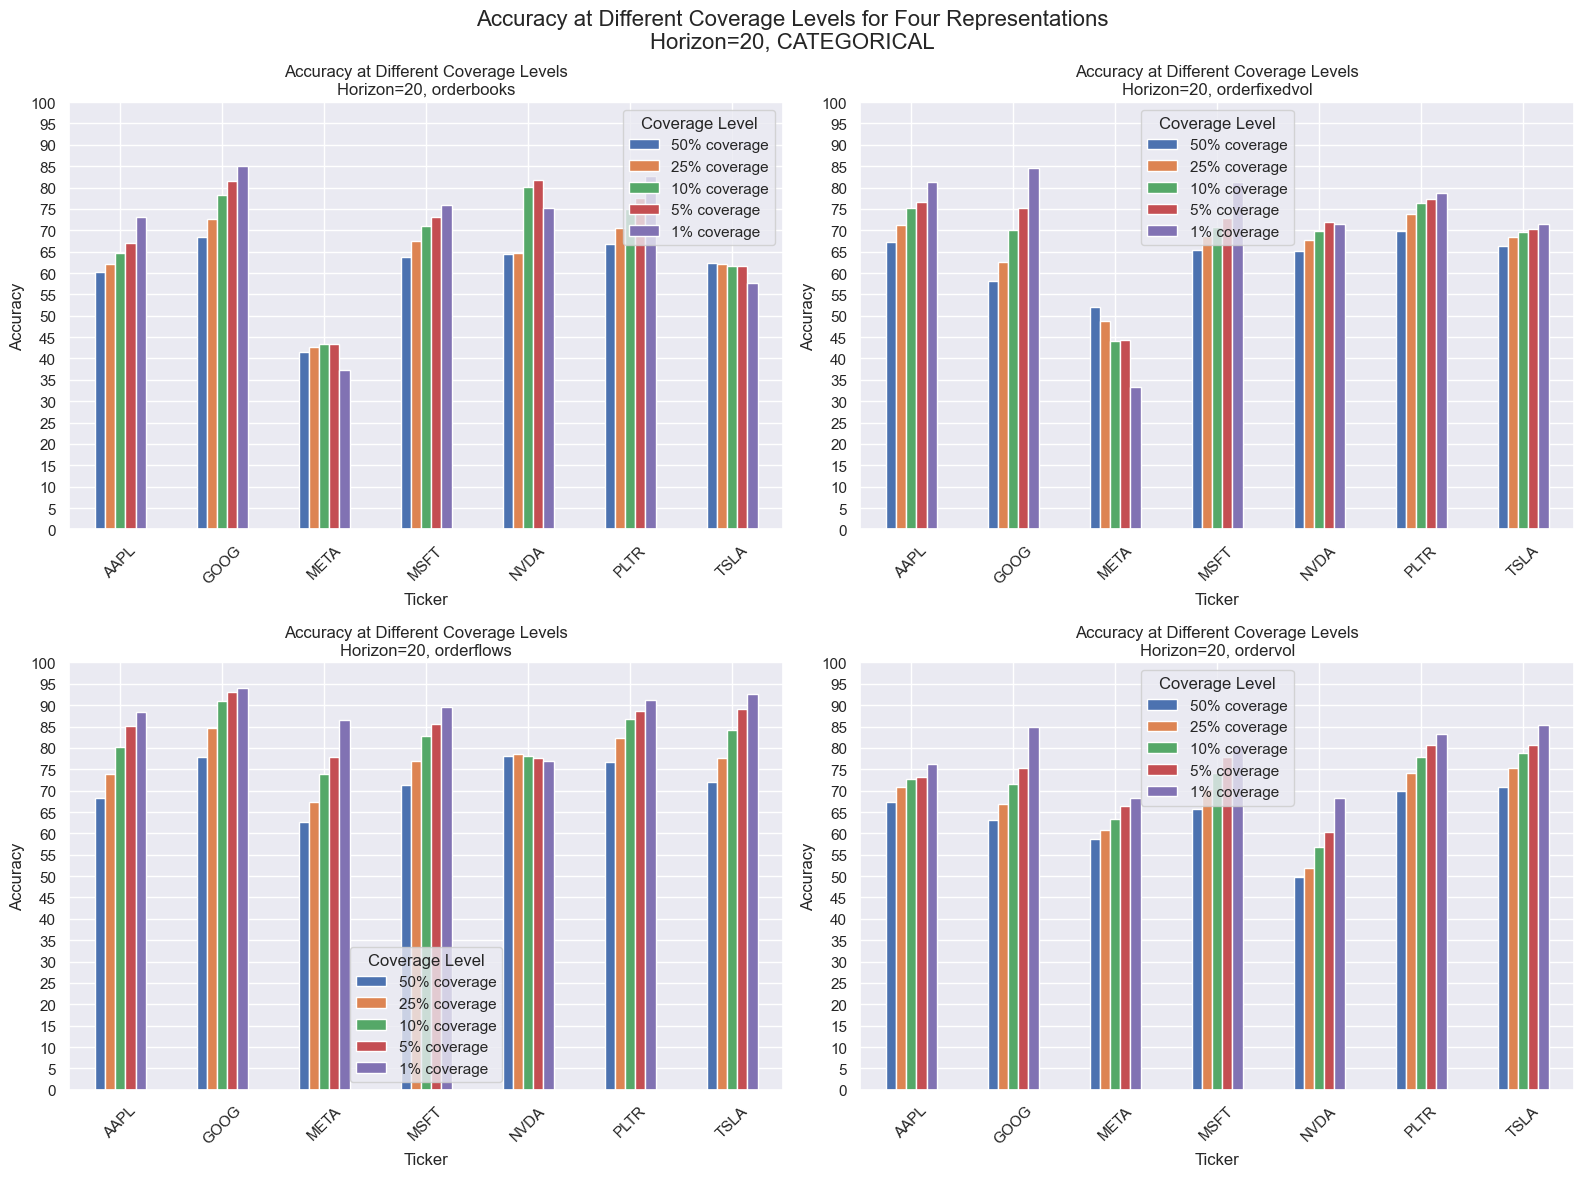

In [25]:
# Plot accuracy at different coverage levels for four representations in a 2x2 grid

representations = ['orderbooks', 'orderfixedvol', 'orderflows', 'ordervol']

tickers = ['AAPL', 'GOOG', 'META', 'MSFT', 'TSLA', 'PLTR', 'NVDA']

percentages = [50, 25, 10, 5, 1]

accuracy_cols = [
    f'metricsStrength.accuracy@{pcnt}%_coverage' for pcnt in percentages
]
accuracy_cols_labels = [f"{pcnt}% coverage" for pcnt in percentages]
fixed_horizon = 20

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=False)


for ax, rep in zip(axes.flat, representations):
    df_bar = data.loc[
        (data['meta.representation'] == rep) &
        (data['meta.lookForwardHorizon'] == fixed_horizon) &
        (data['meta.labelType'] == labelType) &
        (data['Ticker'].isin(tickers))
    ]
    plot_df = df_bar[['Ticker'] + accuracy_cols].set_index('Ticker') * 100
    plot_df.plot(kind='bar', ax=ax)
    
    ax.set_title(f'Accuracy at Different Coverage Levels\nHorizon={fixed_horizon}, {rep}')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Ticker')
    ax.legend(title='Coverage Level')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.grid(axis='y')
    ax.legend(title='Coverage')
    # Add horizontal ytick markers (grid lines)
    ax.yaxis.grid(True, which='major', linestyle='-', alpha=1)
    ax.set_yticks(np.arange(0, 101, 5))
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.legend(accuracy_cols_labels, title='Coverage Level')
    # ax.set_xticks(np.arange(10, 210, 10))

    plt.suptitle("Accuracy at Different Coverage Levels for Four Representations\nHorizon=20, CATEGORICAL", fontsize=16)
plt.tight_layout()
plt.show()


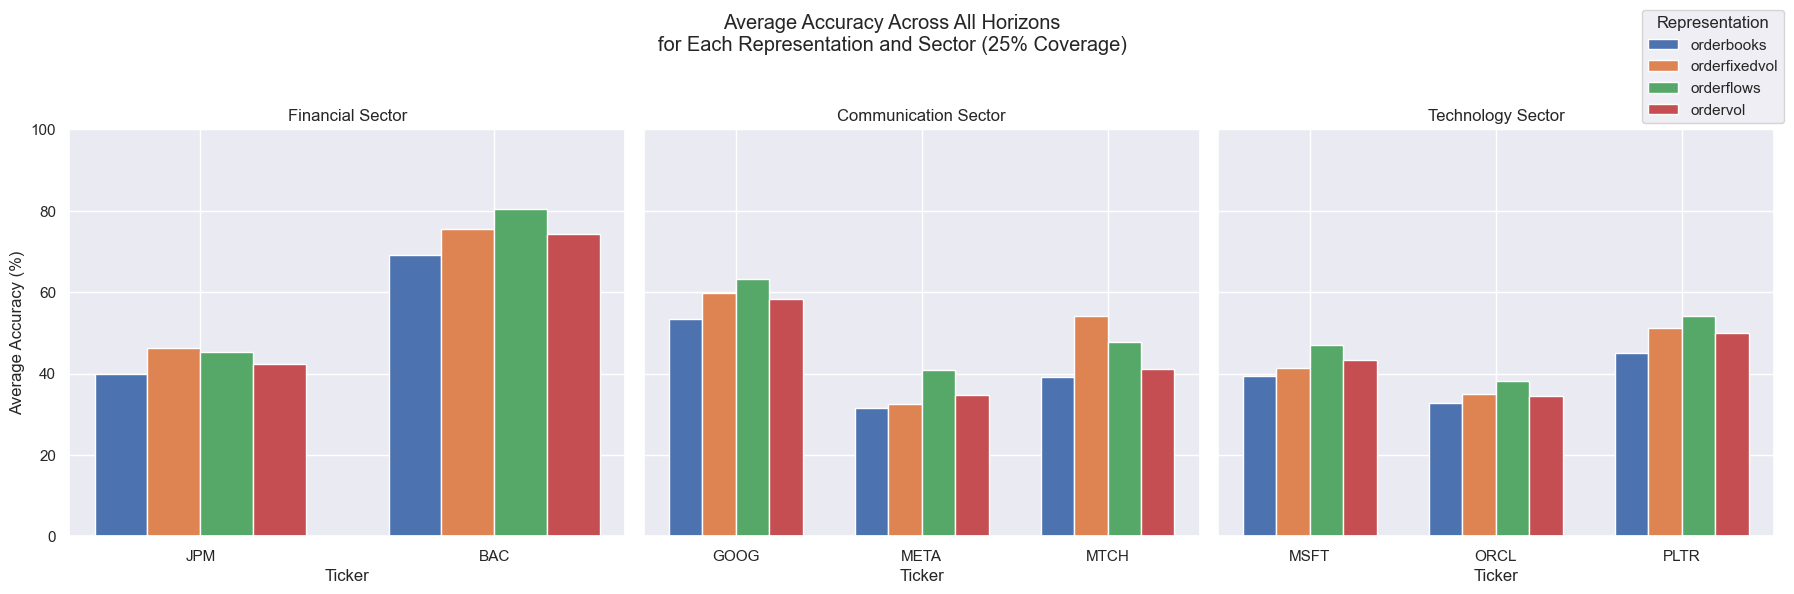

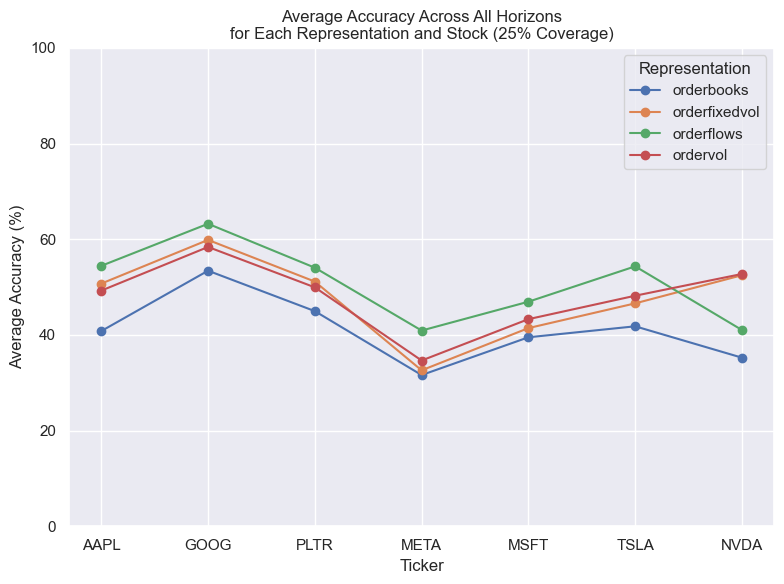

In [37]:
labelType = 'CATEGORICAL'
accuracy_col = 'metricsStrength.accuracy@25%_coverage'
tickers = ['AAPL', 'GOOG', 'PLTR',  'META', 'MSFT', 'TSLA', 'NVDA']
sector_groups = {
    'Financial': ['JPM', 'BAC'],
    'Communication': ['GOOG', 'META', 'MTCH'],
    'Technology': ['MSFT', 'ORCL', 'PLTR']
}
sns.set_theme(context='notebook')
representations = ['orderbooks', 'orderfixedvol', 'orderflows', 'ordervol']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
bar_width = 0.18
for ax, (sector, sector_tickers) in zip(axes, sector_groups.items()):
    x = np.arange(len(sector_tickers))
    for i, rep in enumerate(representations):
        avg_acc = []
        for ticker in sector_tickers:
            subset = data[
                (data['meta.ticker'] == ticker) &
                (data['meta.labelType'] == labelType) &
                (data['meta.representation'] == rep)
            ]
            acc_vals = subset[accuracy_col].dropna()
            avg_acc.append(acc_vals.mean() * 100 if not acc_vals.empty else np.nan)
        ax.bar(x + i * bar_width, avg_acc, width=bar_width, label=rep)
    ax.set_xticks(x + bar_width * (len(representations) - 1) / 2)
    ax.set_xticklabels(sector_tickers)
    ax.set_title(f"{sector} Sector")
    ax.set_xlabel('Ticker')
    ax.grid(True)
axes[0].set_ylabel('Average Accuracy (%)')
axes[0].set_ylim(0, 100)
fig.suptitle('Average Accuracy Across All Horizons\nfor Each Representation and Sector (25% Coverage)')
fig.legend(representations, title='Representation', loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
representations = ['orderbooks', 'orderfixedvol', 'orderflows', 'ordervol']

fig, ax = plt.subplots(figsize=(8, 6))

for rep in representations:
    avg_acc = []
    for ticker in tickers:
        subset = data[
            (data['meta.ticker'] == ticker) &
            (data['meta.labelType'] == labelType) &
            (data['meta.representation'] == rep)
        ]
        acc_vals = subset[accuracy_col].dropna()
        avg_acc.append(acc_vals.mean() * 100 if not acc_vals.empty else np.nan)
    ax.plot(tickers, avg_acc, marker='o', label=rep)

ax.set_xlabel('Ticker')
ax.set_ylabel('Average Accuracy (%)')
ax.set_title('Average Accuracy Across All Horizons\nfor Each Representation and Stock (25% Coverage)')
ax.legend(title='Representation')
ax.grid(True)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()


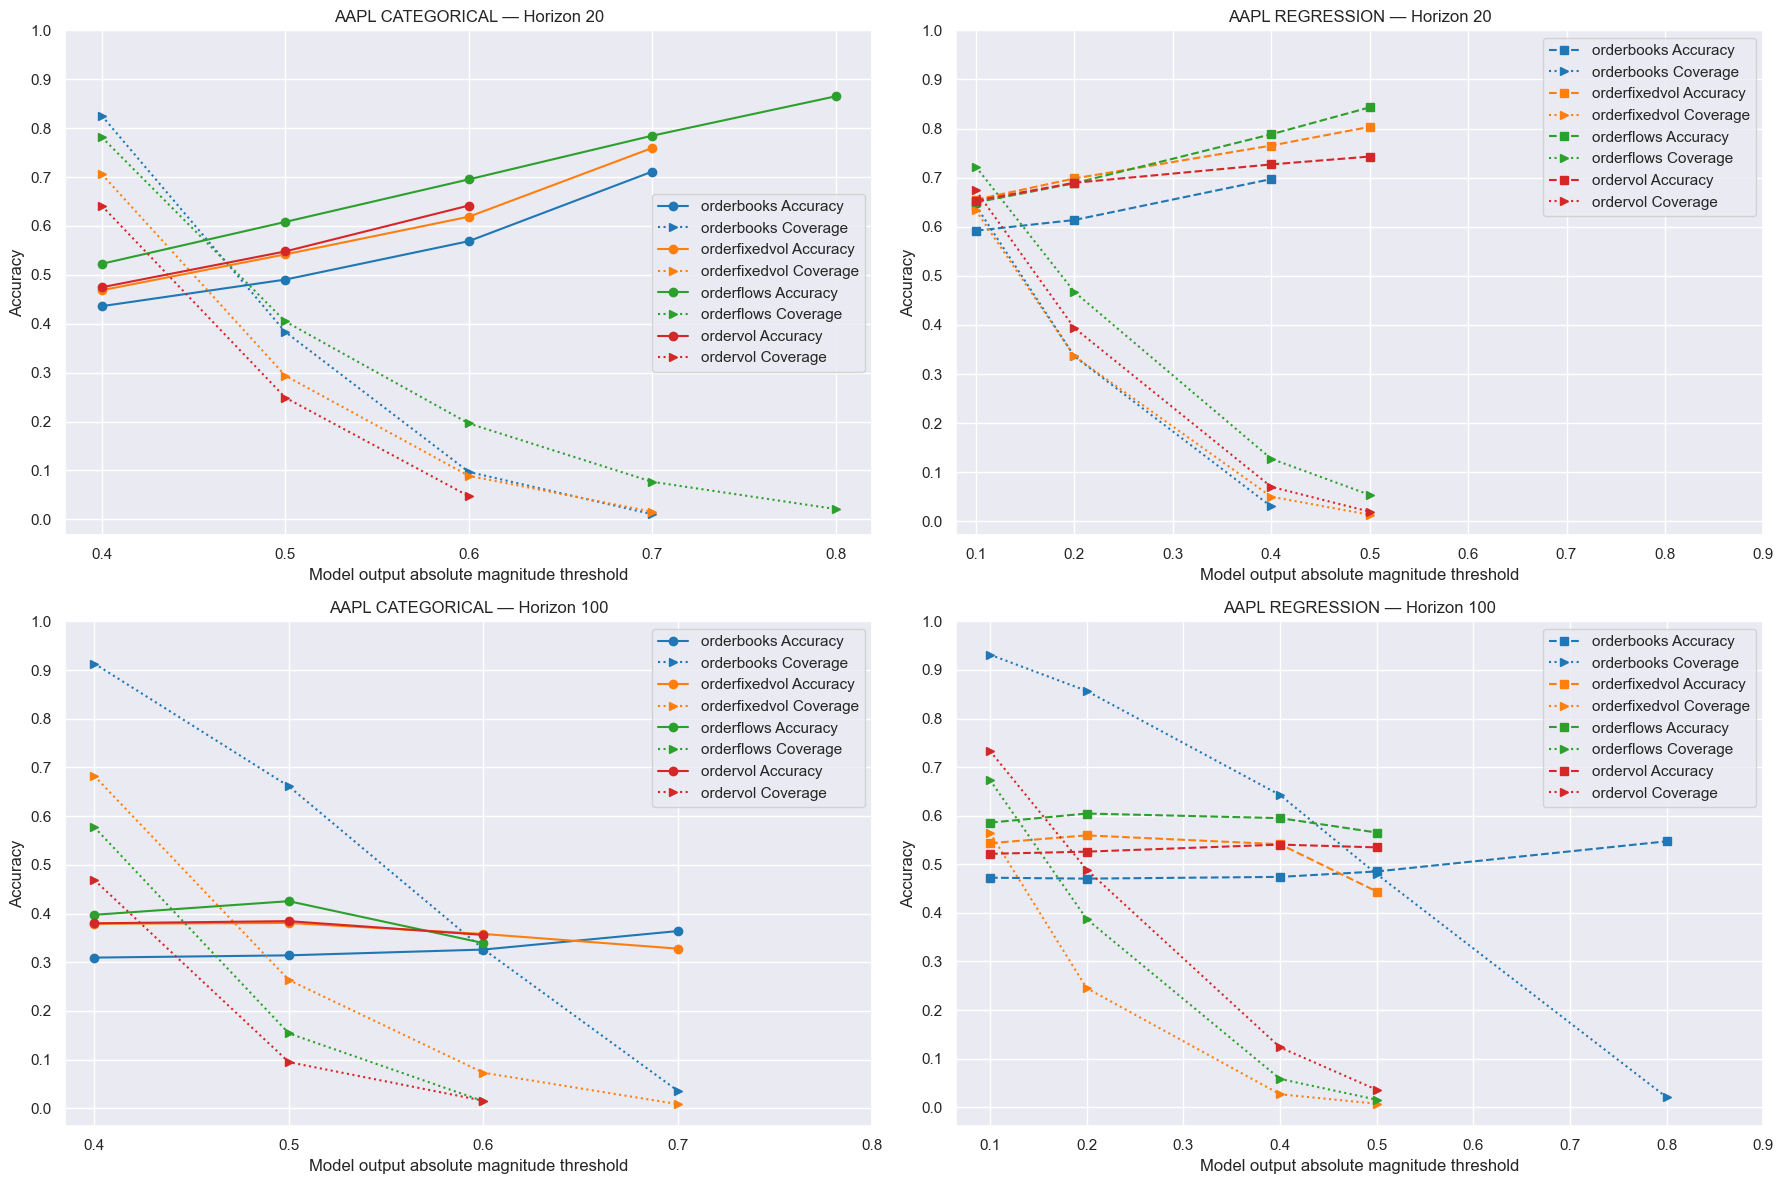

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Horizons and thresholds
horizons = [20, 100]
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
thresholds_all = [0.1 * i for i in range(10)]
sns.set()
representations = data['Representation'].unique()

# Create 2x2 grid once
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharey=False)
colors = plt.cm.tab10.colors
coverage_lim = 0.005

# Mapping horizon/labelType → subplot position
axis_map = {
    (20, "CATEGORICAL"): axes[0, 0],
    (20, "REGRESSION"): axes[0, 1],
    (100, "CATEGORICAL"): axes[1, 0],
    (100, "REGRESSION"): axes[1, 1],
}

for horizon in horizons:
    for labelType in ["CATEGORICAL", "REGRESSION"]:
        ax = axis_map[(horizon, labelType)]
        for idx, rep in enumerate(representations):
            subset = data[
                (data['meta.ticker'] == 'AAPL') &
                (data['meta.labelType'] == labelType) &
                (data['meta.lookForwardHorizon'] == horizon) &
                (data['meta.representation'] == rep)
            ]
            acc_y, cov_y, x_vals = [], [], []
            threshes = thresholds if labelType == 'CATEGORICAL' else thresholds_all

            for thresh in threshes:
                acc_col = f'metricsStrength.accuracy@>{thresh}'
                cov_col = f'metricsStrength.coverage@>{thresh}'
                if (
                    acc_col in subset.columns and
                    cov_col in subset.columns and
                    not subset.empty and
                    subset.iloc[0][cov_col] > coverage_lim
                ):
                    acc_val = subset.iloc[0][acc_col]
                    cov_val = subset.iloc[0][cov_col]
                    if not pd.isna(acc_val) and not pd.isna(cov_val):
                        x_vals.append(thresh)
                        acc_y.append(acc_val)
                        cov_y.append(cov_val)

            color = colors[idx % len(colors)]
            
            if labelType == 'CATEGORICAL':
                ax.plot(x_vals, acc_y, marker='o', label=f'{rep} Accuracy', color=color)
            elif labelType == 'REGRESSION':
                ax.plot(x_vals, acc_y, marker='s', label=f'{rep} Accuracy', color=color, linestyle='--')
            
            ax.plot(x_vals, cov_y, marker='>', label=f'{rep} Coverage', color=color, linestyle=':')

        ax.set_title(f'AAPL {labelType} — Horizon {horizon}')
        ax.set_xlabel('Model output absolute magnitude threshold')
        ax.set_ylabel('Accuracy')
        ax.grid(True)
        ax.legend()
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        
        if labelType == 'CATEGORICAL':
            ax.set_xticks(np.arange(0.4, 0.9, 0.1))
        elif labelType == 'REGRESSION':
            ax.set_xticks(np.arange(0.1, 1, 0.1))


plt.tight_layout()
plt.show()


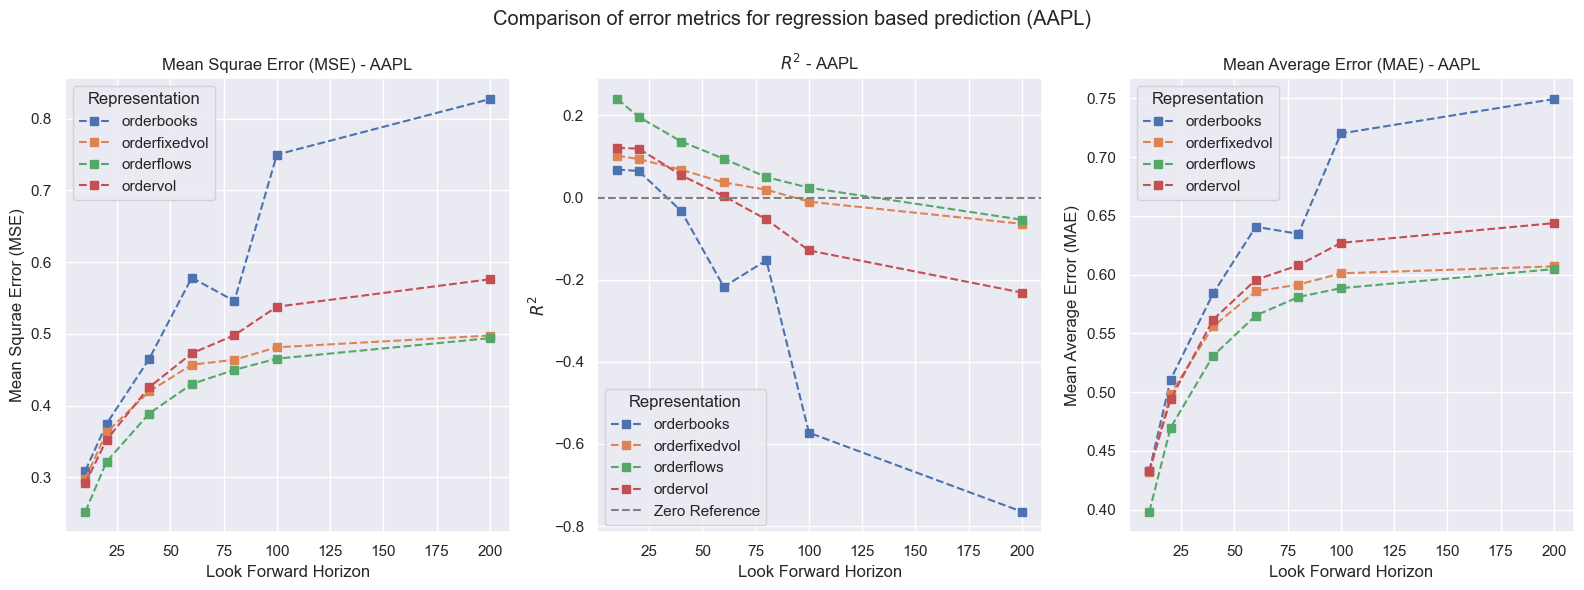

In [76]:
# Plot metrics for REGRESSION format: 'metrics.MSE', 'metrics.R2', 'metrics.MAPE', 'metrics.MAE'
ticker = 'AAPL'
metrics_to_plot = [('metrics.MSE', 'Mean Squrae Error (MSE)'), ('metrics.R2', '$R^2$'), ('metrics.MAE', 'Mean Average Error (MAE)')]

regression_df = data[
    (data['meta.labelType'] == 'REGRESSION') &
    (data['Ticker'] == ticker)
].sort_values('meta.lookForwardHorizon')

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
axes = axes.flatten()

for ax, metric in zip(axes, metrics_to_plot):
    for rep in regression_df['meta.representation'].unique():
        subset = regression_df[regression_df['meta.representation'] == rep]
        ax.plot(
            subset['meta.lookForwardHorizon'],
            subset[metric[0]],
            marker='s',
            linestyle='--',
            label=rep
        )
    if metric[0] == 'metrics.R2':
        ax.axhline(0, color='gray', linestyle='--', label='Zero Reference')
    ax.set_title(f"{metric[1]} - {ticker}")
    ax.set_xlabel('Look Forward Horizon')
    ax.set_ylabel(f"{metric[1]}")
    ax.grid(True)
    ax.legend(title='Representation')
plt.suptitle(f"Comparison of error metrics for regression based prediction ({ticker})")
plt.tight_layout()
plt.show()

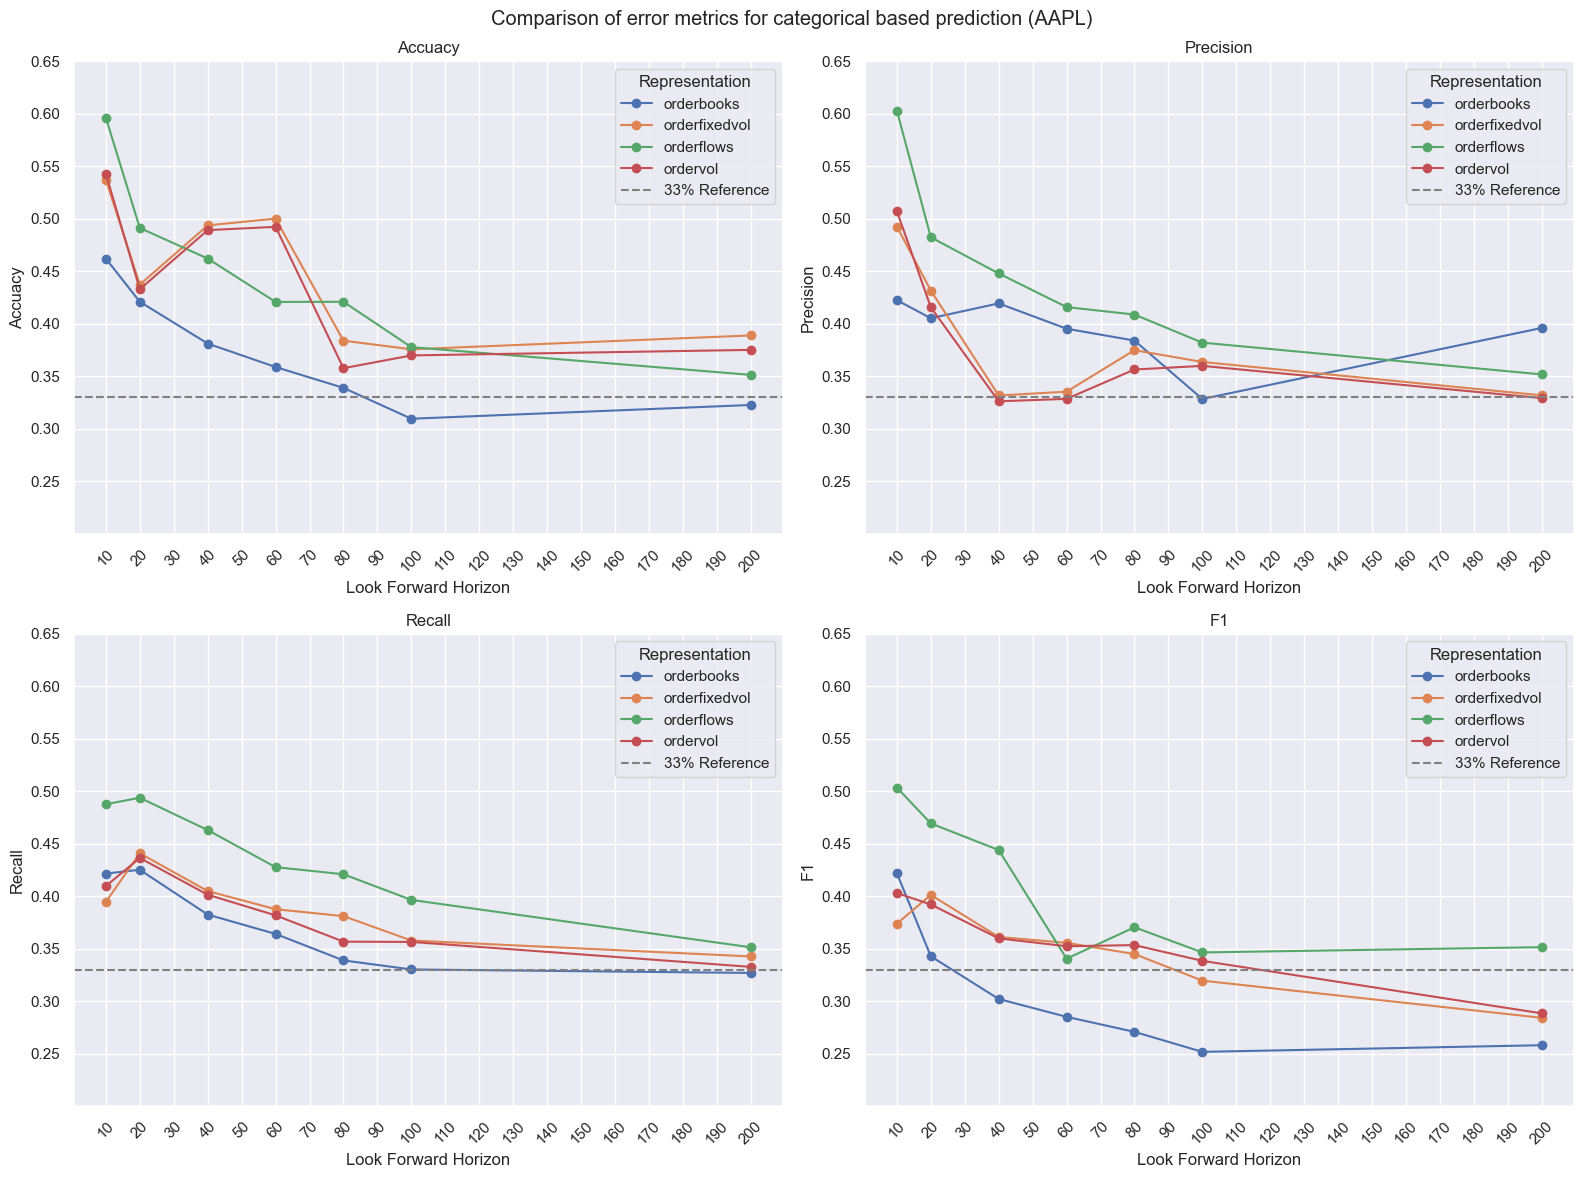

In [108]:
# Plot metrics for CATEGORICAL format: 'metrics.accuracy', 'metrics.precision', 'metrics.recall', 'metrics.f1'
ticker = 'AAPL'

metrics_to_plot = [
    ('metrics.accuracy', 'Accuacy'),
    ('metrics.precision', 'Precision'),
    ('metrics.recall', 'Recall'),
    ('metrics.f1', 'F1')
]

categorical_df = data[
    (data['meta.labelType'] == 'CATEGORICAL') &
    (data['Ticker'] == ticker)
].sort_values(x_axis_col)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, metric in zip(axes, metrics_to_plot):
    for rep in categorical_df['meta.representation'].unique():
        subset = categorical_df[categorical_df['meta.representation'] == rep]
        ax.plot(
            subset[x_axis_col],
            subset[metric[0]],
            marker='o',
            label=rep
        )
    ax.axhline(0.33, color='grey', linestyle='--', label='33% Reference')
    ax.set_title(metric[1])
    ax.set_xlabel('Look Forward Horizon')
    ax.set_ylabel(metric[1])
    ax.grid(True)
    ax.legend(title='Representation')
    ax.set_ylim(0.2, 0.6)
    ax.set_yticks(np.arange(0.25, 0.7, 0.05))
    ax.set_xticks(np.arange(10, 210, 10))
    plt.setp(ax.get_xticklabels(), rotation=45)

fig.suptitle(f"Comparison of error metrics for categorical based prediction ({ticker})")

plt.tight_layout()
plt.show()

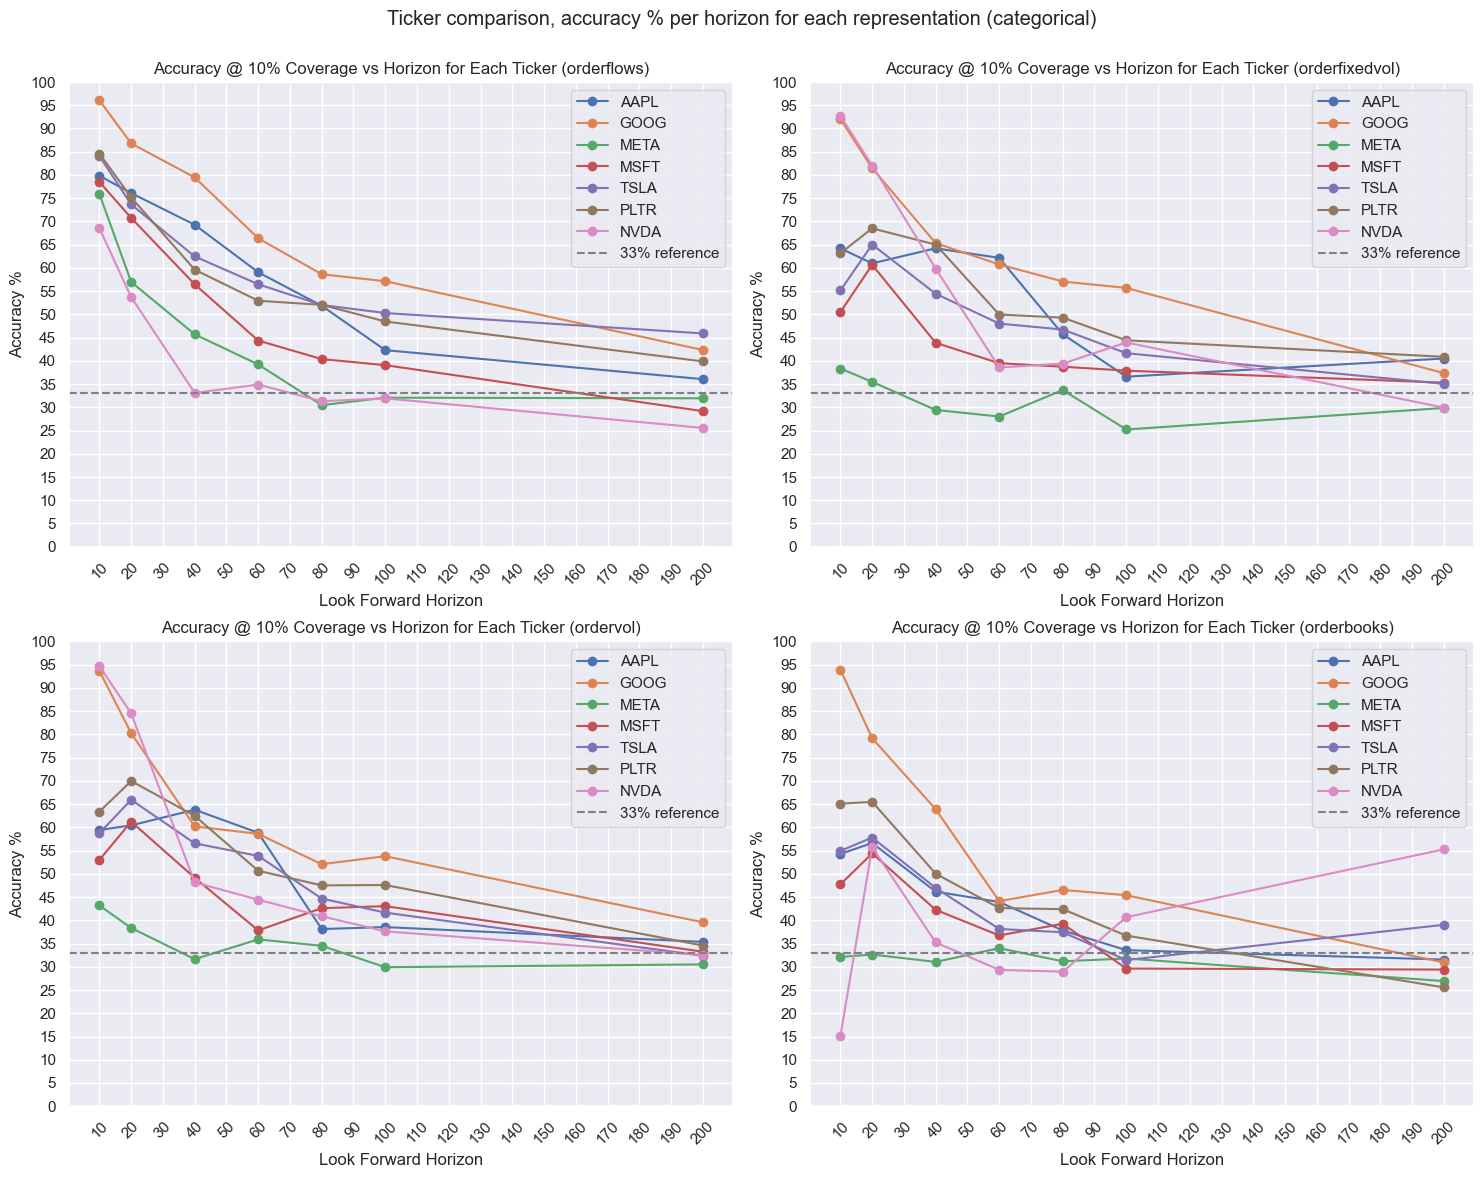

In [107]:
# Plot accuracy@10%_coverage vs horizon for each ticker, for representation 'orderflows'


fig, axs = plt.subplots(2,2, figsize=(15, 12))
axs = axs.flatten()
representations = ['orderflows', 'orderfixedvol', 'ordervol', 'orderbooks']
labelType = "CATEGORICAL"
pcnt = 10
y_axis_col = f'metricsStrength.accuracy@{pcnt}%_coverage'
x_axis_col = 'meta.lookForwardHorizon'

tickers = ['AAPL', 'GOOG', 'META', 'MSFT', 'TSLA', 'PLTR', 'NVDA']

for idx, representation in enumerate(representations):
    for ticker in tickers:
        df = data[
            (data['meta.representation'] == representation) &
            (data['Ticker'] == ticker) &
            (data['meta.labelType'] == labelType)
        ].sort_values(x_axis_col)
        axs[idx].plot(
            df[x_axis_col],
            df[y_axis_col] * 100,
            marker='o',
            label=ticker
        )
    axs[idx].set_xlabel('Look Forward Horizon')
    axs[idx].set_ylabel(f'Accuracy @ {pcnt}% Coverage')
    axs[idx].set_title(f'Accuracy @ {pcnt}% Coverage vs Horizon for Each Ticker ({representation})')
    axs[idx].legend(title='Ticker')

    axs[idx].set_xlabel('Look Forward Horizon')
    axs[idx].set_ylabel(f'Accuracy %')
    axs[idx].set_title(f'Accuracy @ {pcnt}% Coverage vs Horizon for Each Ticker ({representation})')
    axs[idx].legend(title='Ticker')
    hline = 33
    axs[idx].axhline(hline, color='gray', linestyle='--', label='33% reference')
    axs[idx].legend()
    axs[idx].grid(True)
    
    axs[idx].set_yticks(np.arange(0, 1.05, 0.05) * 100)
    
    axs[idx].set_xticks(np.arange(10, 210, 10))
    plt.setp(axs[idx].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.suptitle("Ticker comparison, accuracy % per horizon for each representation (categorical)")
plt.subplots_adjust(top=0.92)
plt.show()

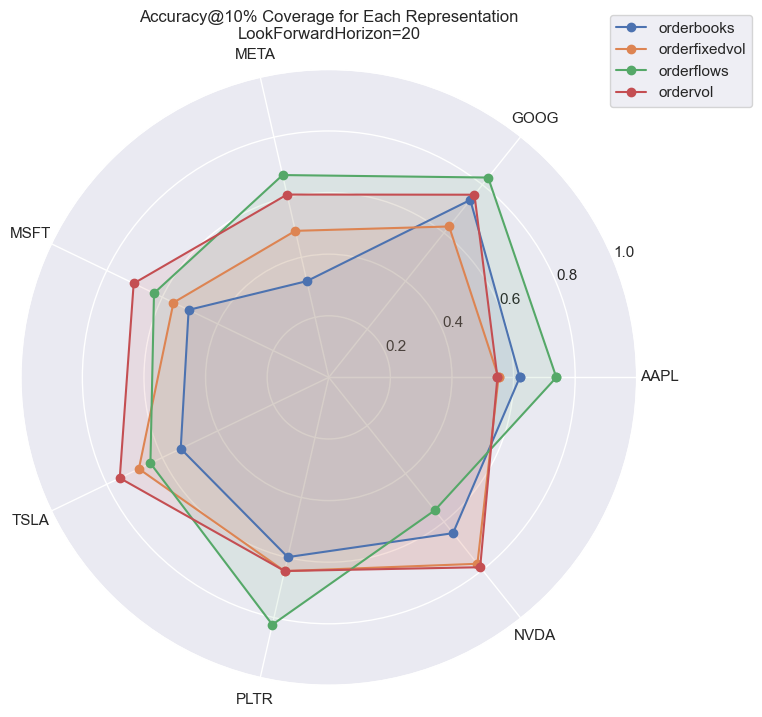

In [173]:
# Spider (Radar) plot: Compare accuracy for each representation across stocks at horizon=20

horizon = 20
pcnt = 25
pcnts = 50, 25, 10, 5
accuracy_col = f'metricsStrength.accuracy@{pcnt}%_coverage'
tickers = ['AAPL', 'GOOG', 'META', 'MSFT', 'TSLA', 'PLTR', 'NVDA']
# Prepare data for radar plot: each representation is a line, corners are stocks
radar_data = []
for rep in representations:
    values = []
    for ticker in tickers:
        row = data[
            (data['meta.representation'] == rep) &
            (data['Ticker'] == ticker) &
            (data['meta.lookForwardHorizon'] == horizon)
        ]
        if not row.empty:
            values.append(row.iloc[0][accuracy_col])
        else:
            values.append(0)
    radar_data.append(values)

angles = np.linspace(0, 2 * np.pi, len(tickers), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for rep, values in zip(representations, radar_data):
    vals = values + values[:1]
    ax.plot(angles, vals, marker='o', label=rep)
    ax.fill(angles, vals, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(tickers)
ax.set_title(f'Accuracy@10% Coverage for Each Representation\nLookForwardHorizon={horizon}')
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


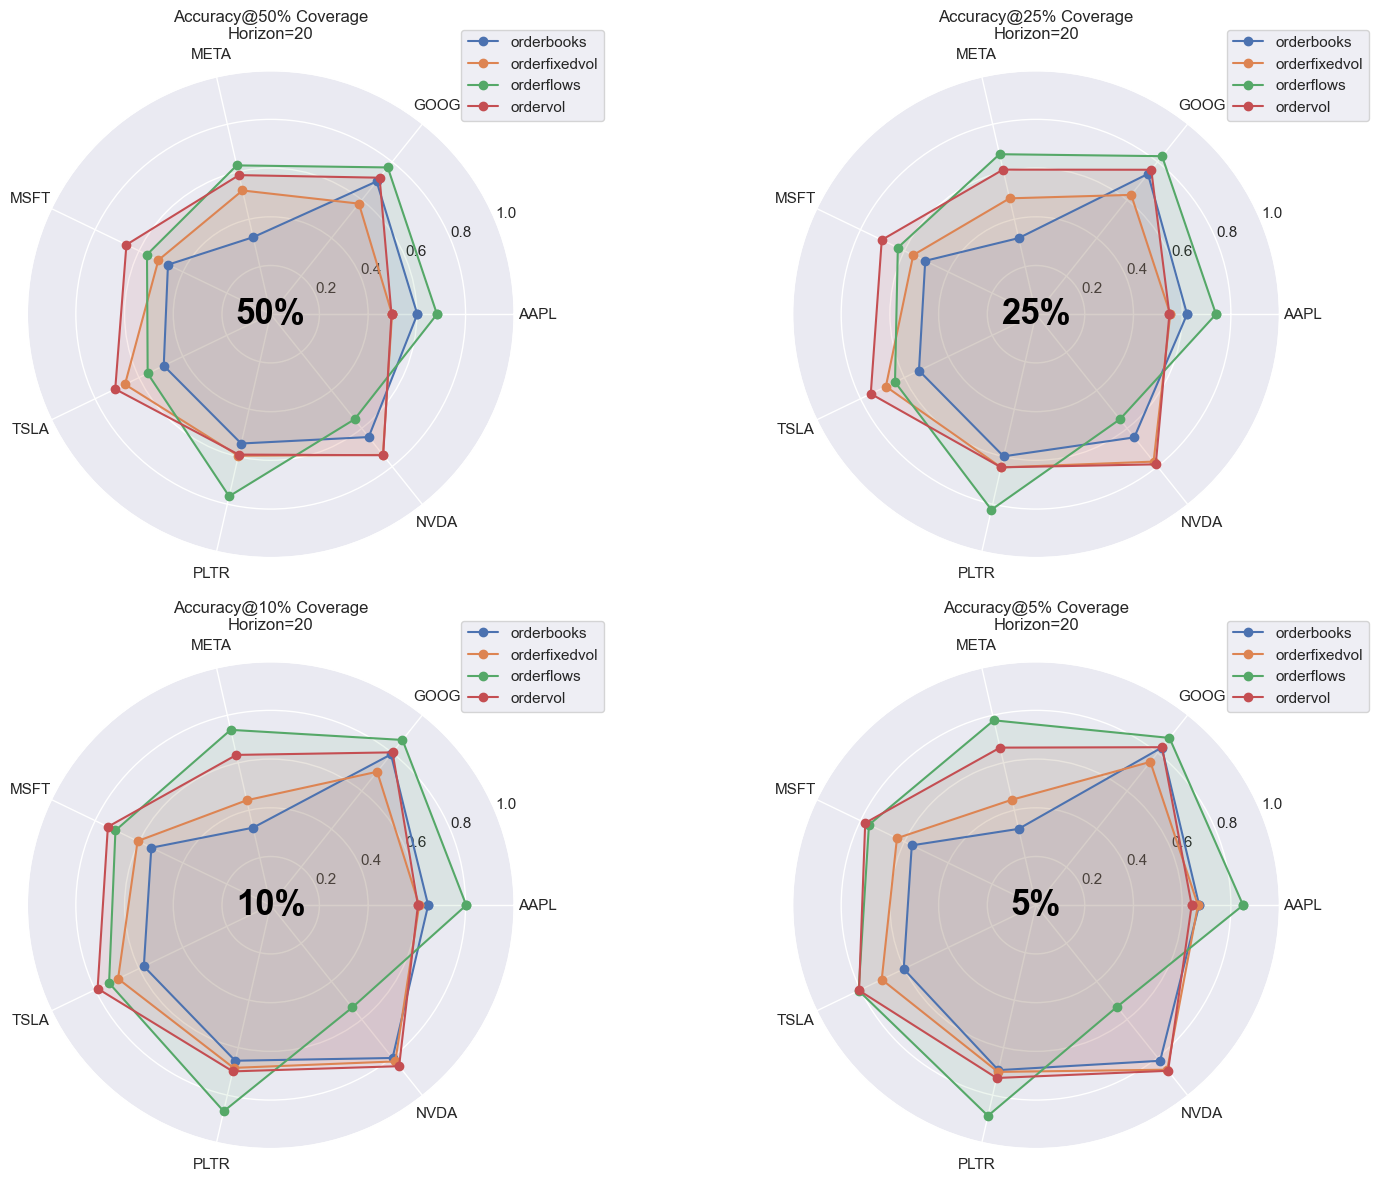

In [39]:
# Spider (Radar) plot: Compare accuracy for each representation across stocks at horizon=20 for each coverage level

horizon = 20
pcnts = [50, 25, 10, 5]
tickers = ['AAPL', 'GOOG', 'META', 'MSFT', 'TSLA', 'PLTR', 'NVDA']

fig, axes = plt.subplots(2, 2, figsize=(16, 12), subplot_kw=dict(polar=True))
for ax, pcnt in zip(axes.flat, pcnts):
    accuracy_col = f'metricsStrength.accuracy@{pcnt}%_coverage'
    radar_data = []
    for rep in representations:
        values = []
        for ticker in tickers:
            row = data[
                (data['meta.representation'] == rep) &
                (data['Ticker'] == ticker) &
                (data['meta.lookForwardHorizon'] == horizon)
            ]
            if not row.empty and accuracy_col in row.columns:
                values.append(row.iloc[0][accuracy_col])
            else:
                values.append(0)
        radar_data.append(values)

    angles = np.linspace(0, 2 * np.pi, len(tickers), endpoint=False).tolist()
    angles += angles[:1]

    for rep, values in zip(representations, radar_data):
        vals = values + values[:1]
        ax.plot(angles, vals, marker='o', label=rep)
        ax.fill(angles, vals, alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(tickers)
    ax.set_title(f'Accuracy@{pcnt}% Coverage\nHorizon={horizon}')
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    # Overlay the percentage label in the center
    ax.text(0, 0, f"{pcnt}%", ha='center', va='center', fontsize=25, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


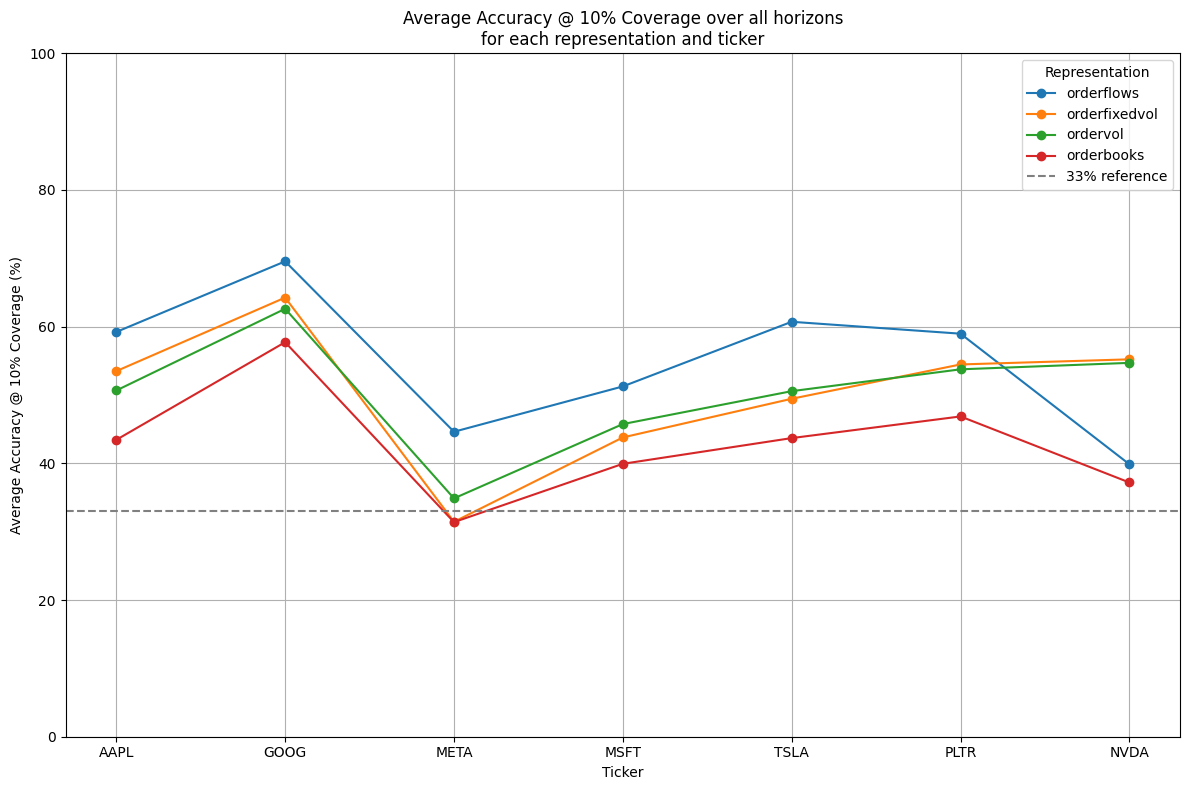

In [5]:
# Plot average accuracy over all horizons for all tickers, for each representation

representations = ['orderflows', 'orderfixedvol', 'ordervol', 'orderbooks']
labelType = "CATEGORICAL"
pcnt = 10
y_axis_col = f'metricsStrength.accuracy@{pcnt}%_coverage'
tickers = ['AAPL', 'GOOG', 'META', 'MSFT', 'TSLA', 'PLTR', 'NVDA']

fig, ax = plt.subplots(figsize=(12, 8))

for rep in representations:
    avg_acc = []
    for ticker in tickers:
        df = data[
            (data['meta.representation'] == rep) &
            (data['Ticker'] == ticker) &
            (data['meta.labelType'] == labelType)
        ]
        mean_acc = df[y_axis_col].mean() * 100 if not df.empty else np.nan
        avg_acc.append(mean_acc)
    ax.plot(tickers, avg_acc, marker='o', label=rep)

ax.set_xlabel('Ticker')
ax.set_ylabel(f'Average Accuracy @ {pcnt}% Coverage (%)')
ax.set_title(f'Average Accuracy @ {pcnt}% Coverage over all horizons\nfor each representation and ticker')
ax.axhline(33, color='gray', linestyle='--', label='33% reference')
ax.legend(title='Representation')
ax.grid(True)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()